In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from gpuaffman_networks import ragged_general_network

The parameters of a ragged kauffman network are the number of nodes $N$ and the maximum number of connections to each node $k_{max}$.


In [2]:
N = 10
k_max = 3

A network is completely specified by 3 arrays:

1. A $N$ x $2^{k_{max}}$ binary matrix representing the binary function that updates each node
2. A $N$ x $k_{max}$ integer matrix representing the connections made to each node
3. A $N$ x $k_{max}$ binary matrix representing the active connections, whcih serves to mask (2)


In [3]:
np.random.seed(1323435)
functions = np.random.binomial(1, 0.5, (N, 1 << k_max)).astype(np.bool_)
connectivity = np.random.randint(0, N, (N, k_max)).astype(np.uint8)
used_connectivity = np.random.binomial(1, 0.5, (N, k_max)).astype(np.bool_)

In [4]:
print(np.matrix(functions))
print()
print(np.matrix(connectivity))
print()
print(np.matrix(used_connectivity))


[[ True  True  True  True False False  True False]
 [False  True False  True False  True False False]
 [False  True  True False  True False False  True]
 [ True False False  True  True  True  True False]
 [False False  True False False False False  True]
 [ True False  True False  True  True False False]
 [False False  True False False  True False  True]
 [ True  True  True False False  True False False]
 [ True  True False  True  True  True  True  True]
 [ True False  True False False False False False]]

[[3 4 0]
 [6 4 6]
 [1 9 9]
 [4 3 8]
 [3 0 2]
 [4 4 5]
 [4 7 2]
 [3 7 0]
 [3 3 2]
 [4 5 8]]

[[ True  True  True]
 [False  True  True]
 [False False False]
 [ True False False]
 [False  True  True]
 [ True  True False]
 [False  True False]
 [ True  True  True]
 [ True  True False]
 [ True  True  True]]


In [11]:
def graph_from_ragged_spec(connections, used_connections, node_labels=None):
    if node_labels is None:
        node_labels = np.arange(start=0, stop=np.shape(connections)[0], step=1)
    g = nx.MultiDiGraph()
    g.add_nodes_from(node_labels)
    for i, (c, u) in enumerate(zip(connections, used_connections)):
        this_cons = np.squeeze(c[np.argwhere(u == 1)], -1)
        edges = []
        for x in this_cons:
            edges.append((node_labels[x], node_labels[i]))

        g.add_edges_from(edges)
    return g

def plot_network_directed(graph, pos, ax, node_colors):
    labels = {}
    for node in graph.nodes():
        labels[node]=node
    nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color=node_colors)
    nx.draw_networkx_edges(graph, pos=pos, arrowstyle="->", ax=ax, arrows=True)
    nx.draw_networkx_labels(graph, pos, labels, ax=ax)

This can be visualized as a directed graph. The direction of the edges indicates the direction of information flow through the network. The head node is updated by each tail node at every timestep.


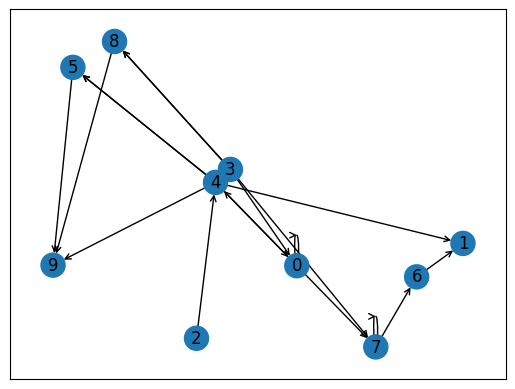

In [12]:
fig, axs = plt.subplots()
g = graph_from_ragged_spec(connectivity, used_connectivity)
pos = nx.spring_layout(g)
plot_network_directed(g, pos, axs, ["C0"] * N)

Given these 3 matricies and an initial state, we can simulate the trajectory of the network for all future times.


Text(0, 0.5, 'Time')

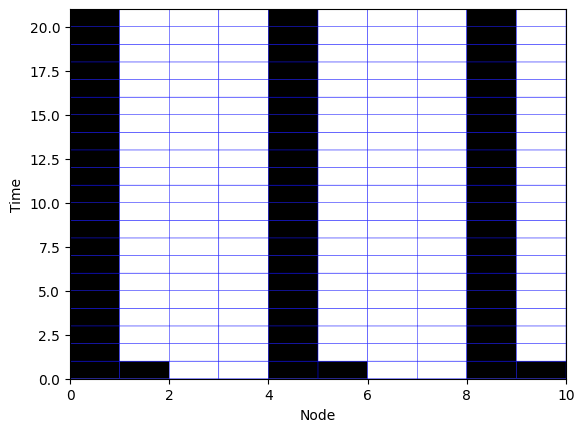

In [13]:
fig, axs = plt.subplots()
n_steps = 20
init_state = np.random.binomial(1, 0.5, N).astype(np.bool_)
all_states = np.moveaxis(np.tile(np.expand_dims(init_state, -1), n_steps+1), -1, 0)
for i in range(n_steps):
    all_states[i+1] = ragged_general_network.ragged_k_state_update(all_states[i], functions, connectivity, used_connectivity)
axs.pcolor(all_states, cmap="Greys", linewidth=0.3, edgecolors="blue")
axs.set_xlabel("Node")
axs.set_ylabel("Time")

We can also simulate arbitrary batches of networks:

In [18]:
batch_shape = (10, 3, 5)
state_batch = np.random.binomial(1, 0.5, (*batch_shape, N)).astype(np.bool_)
function_batch = np.random.binomial(1, 0.5, (*batch_shape, N, 1 << k_max)).astype(np.bool_)
connectivity_batch = np.random.randint(0, N, (*batch_shape, N, k_max)).astype(np.uint8)
used_connectivity_batch = np.random.binomial(1, 0.5, (*batch_shape, N, k_max)).astype(np.bool_)
ragged_general_network.ragged_k_state_update(state_batch, function_batch, connectivity_batch, used_connectivity_batch)

array([[[[False, False,  True, ...,  True,  True, False],
         [ True,  True,  True, ...,  True, False, False],
         [ True,  True,  True, ..., False, False, False],
         [False, False,  True, ..., False,  True,  True],
         [ True, False,  True, ...,  True,  True, False]],

        [[False, False, False, ..., False,  True,  True],
         [False, False,  True, ..., False, False, False],
         [ True,  True, False, ..., False, False,  True],
         [ True, False, False, ...,  True, False,  True],
         [False, False, False, ...,  True, False,  True]],

        [[ True,  True,  True, ...,  True, False,  True],
         [ True, False,  True, ...,  True,  True, False],
         [ True,  True, False, ...,  True,  True, False],
         [False,  True,  True, ...,  True, False,  True],
         [False, False,  True, ..., False, False,  True]]],


       [[[ True, False,  True, ..., False, False,  True],
         [False, False, False, ..., False, False,  True],
      

We can run on an NVIDIA GPU using cupy:


In [19]:
import cupy as cp

In [20]:
init_state_cp = cp.array(init_state)
functions_cp = cp.array(functions)
connectivity_cp = cp.array(connectivity)
used_connectivity_cp = cp.array(used_connectivity)

In [21]:
_ = ragged_general_network.ragged_k_state_update(init_state_cp, functions_cp, connectivity_cp, used_connectivity_cp)

The functions in this library are all agnostic to consistent numpy and cupy inputs.
